## Time Series

Exercises exploring time series pattern identification, as well as the use of different forecasting methods with single and multiple time series. For the most part, we will use a COVID-19 daily cases dataset. 


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

_________________________

#### First, load the dataset:

This dataset is from the first year of the pandemic, up until August 2020. This dataset is a csv file, `assets/time_series_covid19_confirmed_global.csv`, which is part of the [Johns Hopkins University CSSE COVID-19 dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). As the name suggests, it contains the number of *cumulative* confirmed cases globally as of certain dates. However, we are interested in the number of *new* cases worldwide every day for this exercise.

In [2]:
def load_data():
    
    df = pd.read_csv('../assets/time_series_covid19_confirmed_global.csv')
    
    cols_to_drop = ['Province/State', 'Country/Region', 'Lat', 'Long']
    df = df[df.columns.drop(cols_to_drop)]
    
    # create total column, calculate difference
    df.loc['total', :] = df.sum(axis=0)
    df = df.loc['total'].reset_index()
    df['daily_cases'] = df['total'].diff()
    
    # clean up dataset - remove nans, set datetime
    df = df.dropna(subset=['daily_cases'])
    df['index'] = pd.to_datetime(df['index'])
    
    daily_new_cases = pd.Series(df['daily_cases'].values, df['index'])
    
    return daily_new_cases

daily_new_cases = load_data()
daily_new_cases

index
2020-01-23        99.0
2020-01-24       287.0
2020-01-25       493.0
2020-01-26       684.0
2020-01-27       809.0
                ...   
2020-08-17    209672.0
2020-08-18    255096.0
2020-08-19    274346.0
2020-08-20    267183.0
2020-08-21    270751.0
Length: 212, dtype: float64

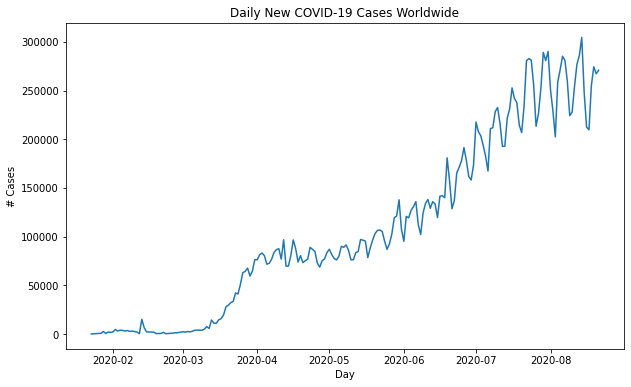

In [3]:
# Let's plot and see the time series

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases)
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")

del fig, ax

#### Seasonal Decomposition

With the time series ready, let's first perform a seasonal decomposition using tools from the `statsmodels` library to get a sense of what the possible patterns are hidden in the data.

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

seasonal = seasonal_decompose(daily_new_cases, model='additive')

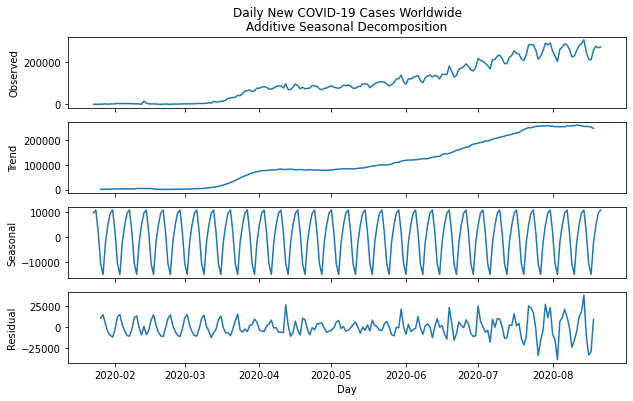

In [5]:
# Let's plot and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(seasonal.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(seasonal.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(seasonal.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(seasonal.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Day")
fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

del fig, axes

#### Fit a Trand Curve
The plot above suggests that there is a non-linear trend hidden in the time series. One approach to discover such a trend is to fit a regression model to the time series and ask the regression model to make predictions at each timestamp. When connected, these chronological predictions form a "trend curve".

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_trend(ser, n):
    """
    Takes a series and fits an n-th order polynomial to the series. 
    Returns the predictions. 
    """
    
    trend_curve = None
    train_X, train_y = None, None # xi's and yi's

    X = np.array([(s - ser.index.min()).days for s in ser.index]) #number of days since start
    y = ser.values

    train_X, train_y = X, y # xi's and yi's
    
    # Fit a polynomial regression model - code given to you
    train_X = PolynomialFeatures(n).fit_transform(train_X.reshape(-1, 1))
    lin_reg = LinearRegression().fit(train_X, train_y.reshape(-1))
    
    # Make predictions to create the trend curve
    trend_curve = lin_reg.predict(train_X)
    
    return trend_curve

In [7]:
trendline = fit_trend(daily_new_cases, 10)

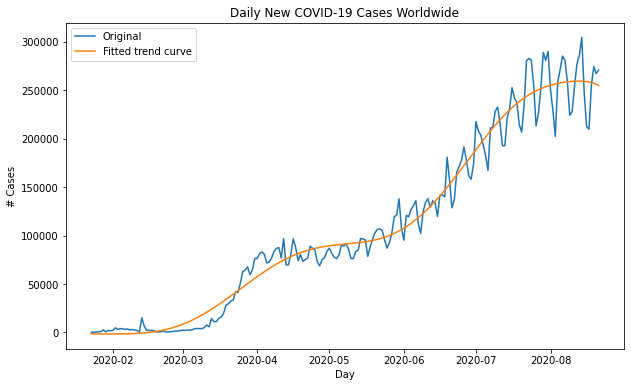

In [8]:
# Let's plot and see your regression line

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, trendline, label="Fitted trend curve")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

______
#### Calculate Weighted Moving Average (WMA)

The regression method seems to give a fairly accurate description of the trend hidden in the time series. Now we will explore an alternative method for discovering trends that is based on moving averages. We will do this without leveraging `pandas.rolling()` for the sake of learning to code problems without it.

The first is Weighted Moving Averages. This method applies weights to the recency of the data, which provides sensitivity to more recent datapoints.

In [9]:
def calc_wma(ser, wd_size, weights=1):
    """
    Takes in a series and calculates the WMA with a window size of wd_size
    """
    wma = []
    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)

    assert len(weights) == wd_size, "Q4: The size of the weights must be the same as the window size. "
    
#     wma = np.array(ser.rolling(wd_size).apply(lambda x: np.dot(x, weights) / weights.sum()))

    for i in range(len(ser)):
        if i < wd_size -1: # starts at 0
            
            temp_ser = ser[0:i+1]
            
            ser_weighted = np.array([a*b for a,b in zip(temp_ser,weights[(wd_size-i-1):])])
            w = (ser_weighted.sum()) / (weights[(wd_size-i-1):].sum()) # WMA
            wma.append(w)
            
        else:
            temp_ser = ser[i - wd_size + 1: i + 1]
            ser_weighted = np.array([a*b for a,b in zip(temp_ser,weights)])
            w = (ser_weighted.sum()) / (weights.sum()) # WMA
            wma.append(w)
    
    return np.array(wma)

In [10]:
wd_size = 7
weights = np.arange(1, wd_size + 1).astype(float)
wma = calc_wma(daily_new_cases, wd_size, weights)

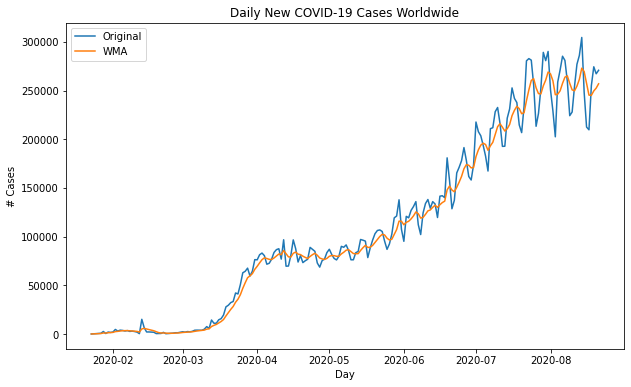

In [11]:
# Let's plot and see WMA

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_new_cases.index, daily_new_cases.values, label="Original")
ax.plot(daily_new_cases.index, wma, label="WMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

#### Calculate "Time" Exponential Moving Average (EMA) 

WMA usually works well if each data point is sampled at regular time intervals (which is the case for our time series). "Time" Exponential Moving Average (EMA), on the other hand, works well on both regular and irregular time series. Let's now explore how to apply EMA to our time series.

EMA, similarly to WMA, provides sensitivity to more recent datapoints, by applying a "decay rate" ($0 \leq \lambda \leq 1$, where $\lambda = 0$ is equal to the cumulative moving average, or CMA).

In [12]:
def calc_time_ema(ser, lmbd=0.0):
    """
    Takes in a series and calculates EMA with the lambda provided
    """
       
    
    if lmbd == 0:
         ema = ser.expanding().mean()
    
    else:
        x = ser
        ema = [x[0]]
        for j in range(1, len(x)):
        
            sumnum = 0
            sumdem = 0
            
            for i in range(j+1):
                
                sumnum += np.exp((x.index[j-1]-x.index[i]).days * -lmbd) * x[i] 
                sumdem += np.exp((x.index[j-1]-x.index[i]).days * -lmbd)
            
            ema.append(sumnum/sumdem)
    
    return np.array(ema)

In [13]:
ema = calc_time_ema(daily_new_cases, lmbd=0.5)

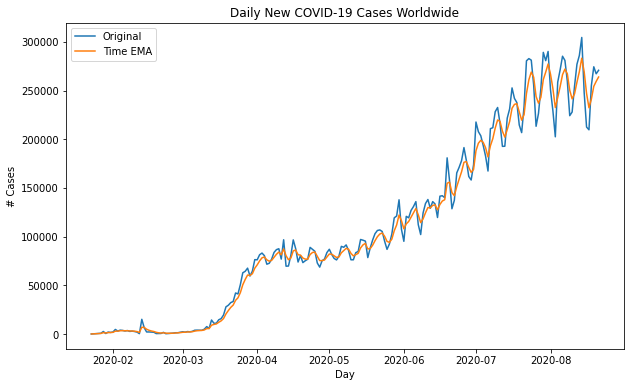

In [14]:
# Let's plot and see your time EMA

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily_new_cases.index, daily_new_cases.to_numpy(), label="Original")
ax.plot(daily_new_cases.index, ema, label="Time EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

Now, in practicality we don't need to build something like that. There is the [`SimpleExpSmoothing`](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#) class from the `statsmodels` library, a handy tool for EMA.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


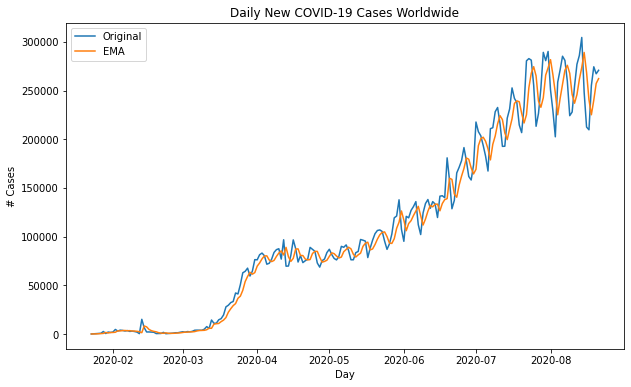

In [15]:
from statsmodels.tsa.api import SimpleExpSmoothing

fig, ax = plt.subplots(figsize=(10, 6))

# Leveraging `SimpleExpSmoothing`
ema_2 = SimpleExpSmoothing(daily_new_cases, initialization_method=None).fit(smoothing_level=0.5, optimized=False)

ax.plot(daily_new_cases, label="Original")
ax.plot(ema_2.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax

______
#### Time Series Similarities

Nex twe will explore techniques for measuring similarity between two time series.

In [16]:
def load_data_5():
    
    df = pd.read_csv('../assets/time_series_covid19_confirmed_global.csv')
    
    cols = list(df['Country/Region'])
    cols_to_drop = ['Province/State', 'Country/Region', 'Lat', 'Long']
    df = df[df.columns.drop(cols_to_drop)]
    
    top_5 = df.nlargest(5, df.columns[-1])
    top_5_cols = [cols[idx] for idx in top_5.index]
    
    daily_new_cases = top_5.T
    daily_new_cases.columns=top_5_cols
    
    for col in top_5_cols:
        daily_new_cases[col] = daily_new_cases[col].diff()
        
    daily_new_cases.dropna(axis=0, how='any', inplace=True)
    daily_new_cases.index = pd.to_datetime(daily_new_cases.index)
    
    return daily_new_cases

all_countries = load_data_5()
all_countries

,US,Brazil,India,Russia,South Africa
2020-01-23,0.0,0.0,0.0,0.0,0.0
2020-01-24,1.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-26,3.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-17,35112.0,19373.0,55018.0,4839.0,2541.0
2020-08-18,44091.0,47784.0,64572.0,4718.0,2258.0
2020-08-19,47408.0,49298.0,69672.0,4790.0,3916.0
2020-08-20,44023.0,45323.0,68900.0,4767.0,3880.0


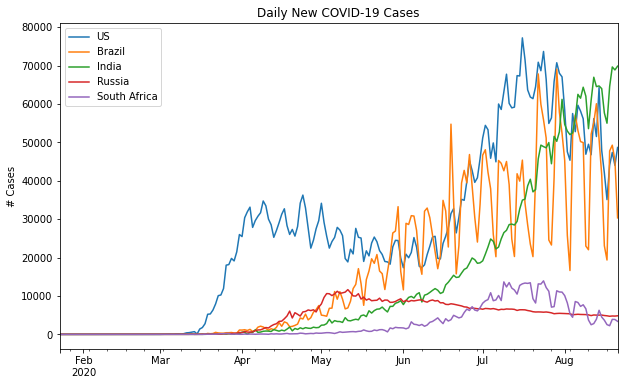

In [17]:
# Let's plot and see the time series
axes = all_countries.plot(figsize=(10, 6), title="Daily New COVID-19 Cases", ylabel="# Cases")

del axes

#### Extract Seasonal Components

In [18]:
def sea_decomp(df, model="additive"):
    """
    Takes in a DataFrame and extracts the seasonal components
    """

    data = {}
    sea_idx = []
    
    for col in df:
        df[col] = seasonal_decompose(df[col], model=model).seasonal
        sea_df = df
    
    return sea_df

In [19]:
sea_df = sea_decomp(all_countries, "additive")

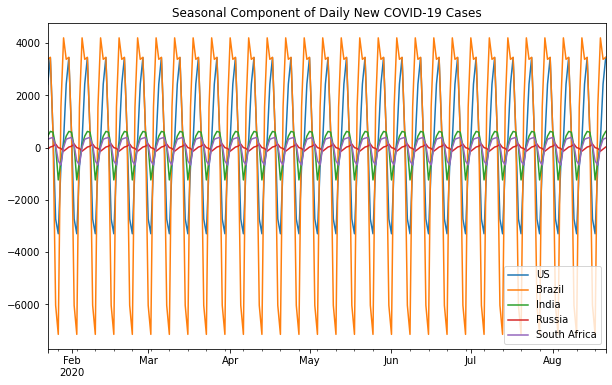

In [20]:
axes = sea_df.plot(figsize=(10, 6), title="Seasonal Component of Daily New COVID-19 Cases")
del axes

#### Euclidian Distance

Now, we may start to ask questions like, "which country in the top 5 countries are the most similar to Country A in terms of seasonal patterns?". In addition to the seasonal components that reflect seasonal patterns, we also need a measure of similarity between two time series in order to answer questions like this. One of such measures is the good old Euclidean Distance. 

In [21]:
i = sea_df.values.T
j = np.nansum((i - i[:, None]) ** 2, axis=2) ** .5
euclidean_dist_df = (lambda v, c: pd.DataFrame(v, c, c))(j, sea_df.columns)

euclidean_dist_df

,US,Brazil,India,Russia,South Africa
US,0.000000,37616.752035,27032.887714,33986.305519,30084.544171
Brazil,37616.752035,0.000000,57583.437987,63663.896821,60839.376478
India,27032.887714,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.305519,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.544171,60839.376478,4490.020448,5658.222387,0.000000


#### Cosine Similarity

Another commonly used similarity measure is the Cosine Similarity.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_df = pd.DataFrame(cosine_similarity(sea_df.T))
cos_m = {k:v for k,v in zip(range(0,sea_df.shape[1]), sea_df.columns)}

cos_sim_df.rename(cos_m, axis='index', inplace=True)
cos_sim_df.rename(cos_m, axis=1, inplace=True)

cos_sim_df

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783851,-0.325065,0.664261
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783851,0.632741,1.000000,0.092292,0.917529
Russia,-0.325065,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664261,0.403198,0.917529,0.174437,1.000000


#### Calculate Dynamic Time Warping Cost

Last but not least, the cost of aligning two time series can also be used as a similarity measure. Two time series are more similar if it incurs less cost to align them. One of the commonly used alignment costs is the Dynamic Time Warping (DTW) cost.

In [23]:
import math

def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """
    Takes in two series. If ret_matrix=True, returns the full DTW cost matrix; 
    otherwise, returns only the overall DTW cost
    """
    
    m,n = len(y), len(x)
    
    cost_matrix = np.zeros((n+1, m+1)) # added 1
    dtw_cost = None
    
    dist_fn = lambda a, b: (a - b) ** 2  # Optional helper function 
    
    for i in range(n+1):
        for j in range(m+1):
            cost_matrix[i, j] = np.inf
    cost_matrix[0,0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = dist_fn(x[i-1],y[j-1])
            last_min = np.min([cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1,j-1]])
            cost_matrix[i,j] = cost+last_min
    
    cost_matrix = np.matrix([row[1:] for row in cost_matrix])
    cost_matrix = cost_matrix[1:].T
    
    dtw_cost = cost_matrix[-1,-1]
    
    return cost_matrix if ret_matrix else dtw_cost

In [24]:
calc_pairwise_dtw_cost(all_countries.iloc[:, 0],all_countries.iloc[:, 1], ret_matrix=False)

1016218295.5956454

Now let's compute all pairwise DTW costs for our five time series.

In [25]:
def calc_dtw_cost(df):
    """
    Takes in a DataFrame and computes all pairwise DTW costs
    """
    matrix = [[calc_pairwise_dtw_cost(df[row], df[col]) for col in df.columns]
          for row in df.columns]
    dtw_cost_df = pd.DataFrame(matrix, df.columns, df.columns)
    
    return dtw_cost_df

Now let's calculate the pairwise DTW costs between seasonal patterns. **We will the sqaure root so that we can compare it with the Euclidean Distance**.

In [26]:
np.sqrt(calc_dtw_cost(sea_df))

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000


________
#### Single Time Series Forecasting

Let's first try to understand whether our time series is stationary or not. Recall that a stationary time series has stable statistics, such as constant means and variances, over time. A non-stationary time series would not be very interesting to study, as it is essentially equivalent to a white noise, carrying little information. 

One way of determining stationarity is to calculate some summary statistics. A rolling mean and a rolling standard deviation are the mean and the standard deviation over a rolling window of values. They both have the same length as the original time series.

In [27]:
def calc_rolling_stats(ser, wd_size=7):
    """
    Takes in a series and returns the rolling mean and the rolling std for a window of size wd_size
    """
    
    mean = ser.rolling(wd_size, min_periods=1).mean()
    std = ser.rolling(wd_size, min_periods=1).std(ddof=0)
    
    # Address nans
    if wd_size == 1:
        rolling_std = [ 0 for std in rolling_std]
    
    rolling_mean, rolling_std = np.array(mean), np.array(std)  
    
    return rolling_mean, rolling_std

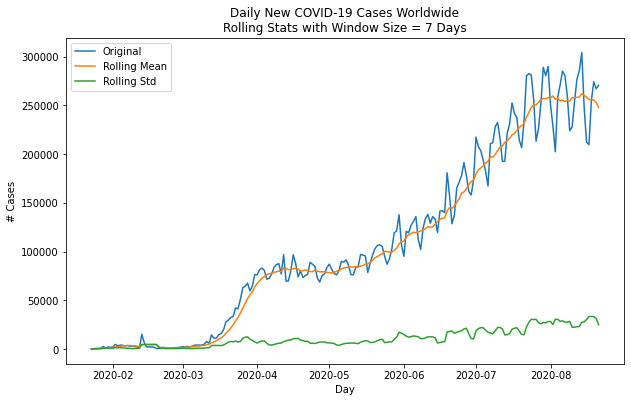

In [28]:
# Calculate rolling statistics
ser, wd_size = daily_new_cases, 7
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(pd.Series(rolling_mean, index=ser.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=ser.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, ser, wd_size, rolling_mean, rolling_std

Now, this is clearly not stationary.

#### Log Return
Let's normalize the data a bit with a log return and see if <i>that</i> is stationary.

In [29]:
def calc_log_ret(ser):
    """
    Takes in a series and computes the log return
    """
    
    log_ret = np.log(ser) - np.log(ser.shift(1))
    log_ret.dropna(inplace=True)
    
    return log_ret

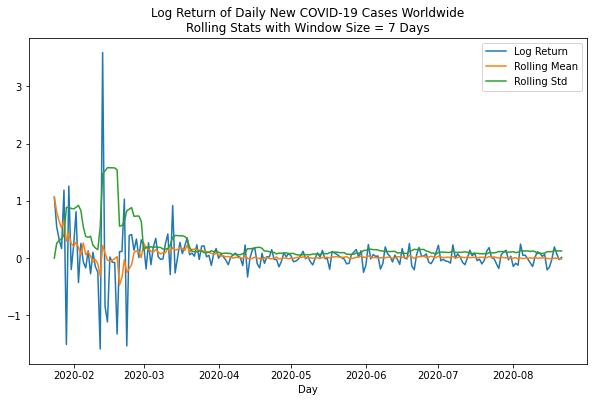

In [30]:
log_ret, wd_size = calc_log_ret(load_data()), 7
rolling_mean, rolling_std = calc_rolling_stats(log_ret, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_ret, label="Log Return")
ax.plot(pd.Series(rolling_mean, index=log_ret.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=log_ret.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_title("Log Return of Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, log_ret, wd_size, rolling_mean, rolling_std

Yet another way of determining stationarity would be to use a statistical test, such as the [Augmented Dickey-Fuller unit root test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null hypothesis is usually that the time series is non-stationary. A $p$-value less than $0.05$ would lead to the conclusion that the time series is stationary, although some [scientists have rised up against this magic number](https://www.nature.com/articles/d41586-019-00857-9).

In [31]:
from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(load_data())
print(f"p-value: {pval}")

del adfuller, pval

p-value: 0.6765852511544095


#### Autocorrelations

Observations in a time series are often not isolated but rather correlated. That is, there might be a correlation between an observation $y_{t}$ and another observation $y_{t - k}$ that is $k$ time steps (or *lags*) earlier. (Partial) autocorrelations precisely capture this idea. 

In [32]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

acf = sm.tsa.acf(daily_new_cases, nlags=30)

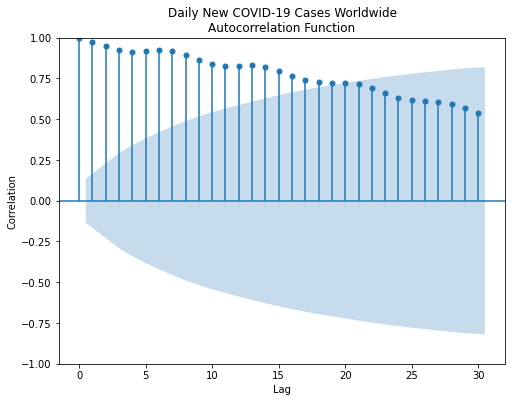

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(daily_new_cases, ax, lags=30, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax

#### Partial Autocorrelation

<b>Autocorrelation</b>, at lag <i>k</i> finds the correlation between series values that are <i>k</i> intervals apart.

<b><i>Partial</i> Autocorrelation</b>, at lag <i>k</i> finds the correlation between series values that are <i>k</i> intervals apart, accounting for the values of the intervals in between (adjusting for presence of all other terms of shorter lag). PACF only describes the direct relationship between an observation and it's lag - which suggests there would be no correlation for lag values beyond <i>k</i>.


In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

pacf = sm.tsa.pacf(daily_new_cases, nlags=30)

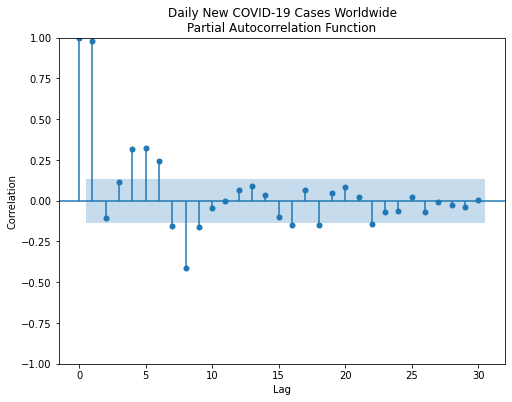

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(daily_new_cases, ax, lags=30, title="Daily New COVID-19 Cases Worldwide\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

_______

#### ARMA on Log Returns

In [36]:
from statsmodels.tsa.arima.model import ARIMA

def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    mod = ARIMA(np.log(ser),order=(p,1,q))
    model_fit = mod.fit()
    forecasts = np.exp(model_fit.forecast(num_forecasts))
    
    
    return forecasts

Let's plot and compare the original time series, the forecasts, and the ground-truth values of the forecasts.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


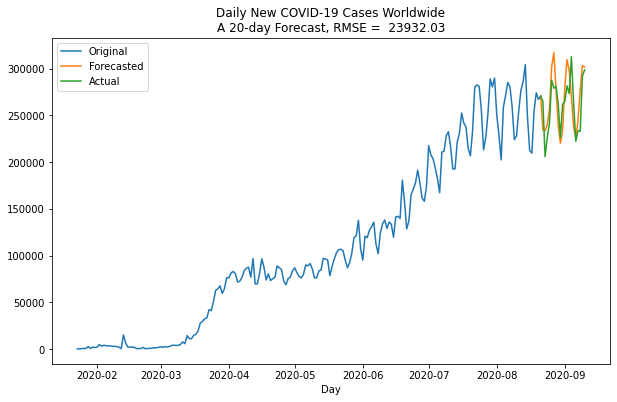

In [37]:
p, q, num_forecasts = 7, 7, 20

forecasts = arma_log_ret(daily_new_cases, p, q, num_forecasts)
actual = pd.read_pickle("../assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_new_cases, label="Original")
ax.plot(daily_new_cases[-1:].append(forecasts), label="Forecasted")
ax.plot(daily_new_cases[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax

Not too bad!

______

### Multiple Time Series Forecasting

#### Vector Autoregression (VAR)

There may be interesting relationships that exist among multiple time series. One way of uncovering such relationships is to perform a VAR, where we model a time series not only with its own observations but also observations from other possibly related time series. Let's apply VAR to the five time series (one from each country) about daily new COVID-19 cases. 

In [38]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """
    data = df.diff().replace([np.inf, -np.inf], np.nan).dropna()
    
    model = VAR(data)
    var_res = model.fit(p)
    
    forecast_out = var_res.forecast(data.values[-p:],steps=num_forecasts)
    
    # create DF
    res = pd.DataFrame(forecast_out, 
                             columns = data.columns, 
                             index = pd.date_range("2020-08-22", periods=num_forecasts, freq="D"))
    
    # need to transform back into non-diff space
    # concat last row orig df, then cum sum, then slice out first row
    forecasts = pd.concat([df[-1:], res], axis=0).cumsum()[1:]
    
    return var_res, forecasts

In [39]:
var_first_diff(all_countries, p=7, num_forecasts=20)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x7faa409b2750>,
                      US       Brazil        India      Russia  South Africa
 2020-08-22   578.564626   586.665963   594.066127   55.034811    391.346141
 2020-08-23 -2728.454422 -6031.950950    46.655454  137.908703     76.880131
 2020-08-24 -3293.854422 -7144.674760 -1234.673118    1.842036   -507.496059
 2020-08-25  -719.521088  1549.577621  -544.749308  -28.929392   -662.877011
 2020-08-26   284.707483  4202.114239    76.125240 -134.659770     16.725452
 2020-08-27  2431.761670  3380.626554   441.179428  -54.886371    322.986535
 2020-08-28  3446.796153  3457.641332   621.396176   23.689984    362.434811
 2020-08-29   578.564626   586.665963   594.066127   55.034811    391.346141
 2020-08-30 -2728.454422 -6031.950950    46.655454  137.908703     76.880131
 2020-08-31 -3293.854422 -7144.674760 -1234.673118    1.842036   -507.496059
 2020-09-01  -719.521088  1549.577621  -544.749308  -28.929392   -662.877011


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


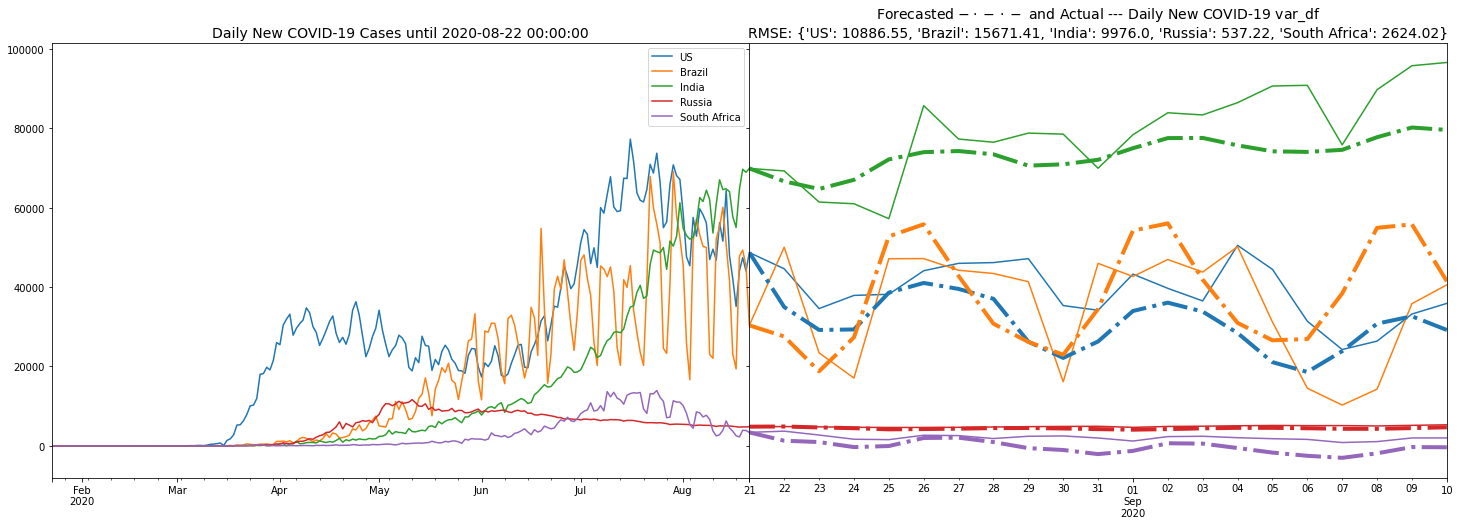

In [40]:
# Let's plot and see the forecasts
p, num_forecasts = 7, 20

var_df = load_data_5()
_, forecasts = var_first_diff(var_df, p, num_forecasts)

# Here is the actual data for comparison
actual = pd.read_pickle("../assets/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

var_df.plot(ax=axes[0])

var_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

var_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * var_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 var_df" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, p, num_forecasts, forecasts, actual, rmse

Now, let's compare the forecasts made by the $\mathrm{VAR(p)}$ model you trained above with that made by five independent $\mathrm{AR(p)}$ models for each time series. This way, we will be able to see the effect of including observations from possibly related time series on modelling each invidual time series more clearly. 

In [41]:
def arma_first_diff(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on first-order diff. 
    Returns a number of forecasts as specified by num_forecasts. 
    """ 
    
    d = 1 # 1st order log difference (log return equivalent)
    arima_model = ARIMA(ser, order=(p, d, q))
    arima_fitted = arima_model.fit()
    forecasts = arima_fitted.forecast(steps=num_forecasts)
    forecasts.index = pd.to_datetime(forecasts.index)
    
    return forecasts

In [42]:
def ar_first_diff(df, p, num_forecasts):
    """
    Fits an AR(p) model on the first-order diff on each time dfies in df and makes num_forecasts forecasts
    """
    q = 0 # Not interested in MA
    forecast_list = []
    for i in range(df.shape[1]):
        forecast_list.append(arma_first_diff(df.iloc[:,i], p, q, num_forecasts))
    forecasts = pd.DataFrame(np.transpose(forecast_list), columns=df.columns, 
                             index=pd.date_range('2020-08-22', periods=num_forecasts))

    return forecasts

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/

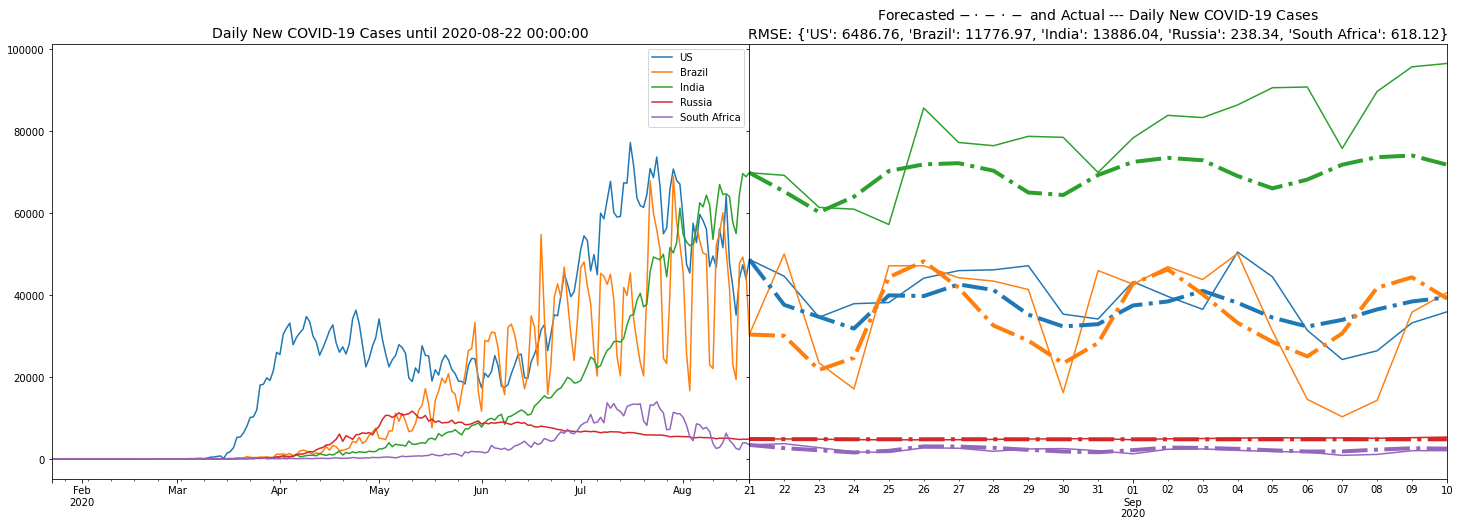

In [43]:
p, num_forecasts = 7, 20

compare_df = load_data_5()
forecasts = ar_first_diff(compare_df, p, num_forecasts)
actual = pd.read_pickle("../assets/actual_multi.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

compare_df.plot(ax=axes[0])

compare_df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

compare_df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * compare_df.shape[-1], linewidth=4)

axes[0].set_title(f"Daily New COVID-19 Cases until {forecasts.index[0]}", fontsize=14)
axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- Daily New COVID-19 Cases" + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

del fig, axes, compare_df, p, num_forecasts, forecasts, actual, rmse

#### Granger Causality

By comparing the forecasts made by a single $\mathrm{VAR}(p)$ model and by five independent $\mathrm{AR}(p)$ models above, you may notice that the RMSE of one country has improved after we "upgrade" an $\mathrm{AR}(p)$ model to include observations from all other time series. It alerts us about the possible *causality* that may exist among these time series, because the inclusion of some other time series enables us to make better forecasts on another one.

This is exactly the principle behind Granger Causality test, a statistical test for causality that works by determining whether the inclusion of one time series significantly improves the prediction of the other. Let's now perform a Granger Causality test on each pair of countries and see what we can conclude. 

In [44]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def test_granger(df, p):
    """
    Fits a VAR(p) model on the input df and performs pairwise Granger Causality tests
    """
    df = df.diff().dropna() # VAR model assumes that data is stationary already

    var_model = VAR(df) # VAR model assumes that data is stationary already
    var_model_fitted = var_model.fit(maxlags=p)

    pval_matrix = []
    for i in range(5):
        pvals_i = []
        for j in range(5):
            if i==j:
                pvals_i.append(np.nan)
            else:
                causality = var_model_fitted.test_causality(i, j, kind='f') # caused, causing
                pvals_i.append(causality.pvalue)
        pval_matrix.append(pvals_i)

    pval_matrix = pd.DataFrame(np.array(pval_matrix), index=df.columns, columns=df.columns)

    return pval_matrix

In [45]:
# Show the causality matrix

gc_df, p = load_data_5(), 7
gc_ans = test_granger(gc_df, 7)
caul_mtrx = gc_ans.rename(index={item: f"{item} caused by" for item in gc_ans.index})
caul_mtrx.where(caul_mtrx.isna(), caul_mtrx <= 0.01)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,US,Brazil,India,Russia,South Africa
US caused by,NaN,True,False,False,False
Brazil caused by,False,NaN,True,False,True
India caused by,False,True,NaN,False,True
Russia caused by,True,False,False,NaN,False
South Africa caused by,False,False,False,False,NaN


______________________
<div style="text-align: right"><sub>Exercise adapted and modified from UMSI homework assignment for SIADS 632.</sub></div>